## Project 3

Dataset: COMPAS

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [46]:
df = pd.read_csv("compas-scores-two-years.csv")
print(df.shape)
print(df.columns)

(7214, 53)
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


We will first fit a model predicting if the person will reoffend in the next two years. We could use a classifier for this. 

Next steps:

* look at the data for bias
* build a classifier

Sensitive variables: race, sex 

Target variable: two_year_recid

Features: age/age_cat, juv_fel_count, juv_misd_count, juv_other_count, priors_count, c_charge_degree, score_text, days_b_screening_arrest, decile_score, length_of_stay

## Categorizing data

In [47]:
df = df[["race", "sex", "age_cat", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "two_year_recid"]]

df = df[(df["c_charge_degree"] != 'O')]

# sum 1-20 together
df["juv_fel_count"] = np.where(df["juv_fel_count"] == 0, 0, 1)
df["juv_misd_count"] = np.where(df["juv_misd_count"] == 0, 0, 1)
df["juv_other_count"] = np.where(df["juv_other_count"] == 0, 0, 1)
df["priors_count"]

df.loc[(df['priors_count'] >= 0) & (df['priors_count'] <= 10), 'priors_count'] = 0
df.loc[(df['priors_count'] > 10) & (df['priors_count'] <= 20), 'priors_count'] = 1
df.loc[(df['priors_count'] > 20), 'priors_count'] = 2

df["c_charge_degree"] = np.where(df["c_charge_degree"] == "M", 0, 1)
df["age_cat"] = df["age_cat"].replace({"Less than 25": 0, "25 - 45": 1, "Greater than 45": 2})
# Filter out other races than african-americans and caucasians
df = df[(df.race == "Caucasian") | (df.race == "African-American")]

df["sensitive"] = df.apply(lambda x: x["race"][0] + x["sex"][0], axis=1)

df.head()
df.to_csv("data_clean.csv")

C:\Users\annku\AppData\Local\Temp\ipykernel_17048\2124011798.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["age_cat"] = df["age_cat"].replace({"Less than 25": 0, "25 - 45": 1, "Greater than 45": 2})


In [48]:
df = pd.read_csv("data_clean.csv")

df_count = df.groupby(["sensitive", "c_charge_degree", "two_year_recid"]).agg(
    count=('race', 'count')).reset_index()

df_sum = df_count.groupby(["sensitive", "c_charge_degree"]).agg(
    sum=('count', 'sum')).reset_index()

df_summary = pd.merge(df_count, df_sum, on=["sensitive", "c_charge_degree"])

df_summary["prob"] = df_summary["count"] / df_summary["sum"]
df_summary = df_summary.sort_values(by="prob", ascending=False)
print(df_summary)

   sensitive  c_charge_degree  two_year_recid  count   sum      prob
8         CF                0               0    190   259  0.733591
0         AF                0               0    157   229  0.685590
12        CM                0               0    459   715  0.641958
2         AF                1               0    248   423  0.586288
10        CF                1               0    178   308  0.577922
7         AM                1               1   1204  2124  0.566855
14        CM                1               0    661  1172  0.563993
4         AM                0               0    470   920  0.510870
5         AM                0               1    450   920  0.489130
15        CM                1               1    511  1172  0.436007
6         AM                1               0    920  2124  0.433145
11        CF                1               1    130   308  0.422078
3         AF                1               1    175   423  0.413712
13        CM                0     

## Model

Define logistic regression.

0.6059620596205962


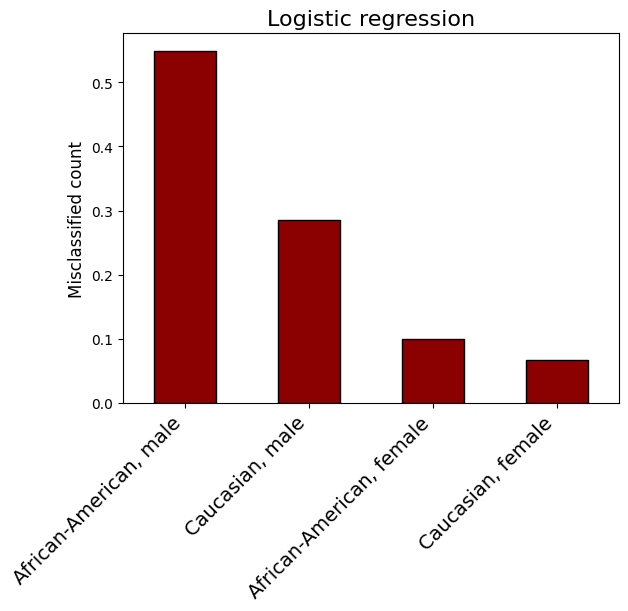

In [ ]:
df = pd.read_csv("data_clean.csv")

# Select relevant columns for features and target
features = df[["juv_fel_count", "juv_misd_count", "priors_count", "c_charge_degree"]]

target = df['two_year_recid']

# Handle missing values if any
features = features.fillna(0)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# calculate number of misclassified samples by group
df_test = X_test.copy()
df_test['two_year_recid_actual'] = y_test
df_test['two_year_recid_predicted'] = y_pred

df_test["sensitive"] = df.loc[df_test.index.values, "sensitive"]

df_test = df_test[df_test["two_year_recid_actual"] != df_test['two_year_recid_predicted']]

# plot samples misclassified, count by sensitive information

df_test["sensitive"] = df_test["sensitive"].replace({"AM": "African-American, male", "AF": "African-American, female",
                                                 "CM": "Caucasian, male", "CF": "Caucasian, female"})

ratio = df_test["sensitive"].value_counts() / df_test.shape[0]

ratio.plot(kind='bar', color='darkred', edgecolor='black')
plt.title('Logistic regression', fontsize=16)
plt.xlabel('')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.ylabel('Misclassified count', fontsize=12)
plt.savefig("logistic.jpg", bbox_inches = 'tight')

In [51]:
df_test = X_test.copy()
df_test['two_year_recid_actual'] = y_test
df_test['two_year_recid_predicted'] = y_pred

df_test["sensitive"] = df.loc[df_test.index.values, "sensitive"]

In [53]:
# twin test for model

df_count = df_test.groupby(["sensitive", "c_charge_degree", "two_year_recid_predicted"]).agg(
    count=('sensitive', 'count')).reset_index()

df_sum = df_count.groupby(["sensitive", "c_charge_degree"]).agg(
    sum=('count', 'sum')).reset_index()

df_summary = pd.merge(df_count, df_sum, on=["sensitive", "c_charge_degree"])

df_summary["prob"] = df_summary["count"] / df_summary["sum"]
df_summary = df_summary.sort_values(by="prob", ascending=False)
print(df_summary)

   sensitive  c_charge_degree  two_year_recid_predicted  count  sum      prob
8         CF                0                         0     68   70  0.971429
10        CF                1                         0     84   87  0.965517
12        CM                0                         0    214  224  0.955357
0         AF                0                         0     60   65  0.923077
14        CM                1                         0    315  354  0.889831
4         AM                0                         0    229  277  0.826715
2         AF                1                         0     97  119  0.815126
6         AM                1                         0    468  649  0.721109
7         AM                1                         1    181  649  0.278891
3         AF                1                         1     22  119  0.184874
5         AM                0                         1     48  277  0.173285
15        CM                1                         1     39  

Note! When looking at c_charge_degree we found that the model was more biased toward African-American males than Caucasian males (prediction for AM 0.5 vs. CM 0.27; in data AM 0.56 and CM 0.43)

In [54]:
df_test = df_test[df_test["two_year_recid_actual"] != df_test['two_year_recid_predicted']]

# samples misclassified, count by sensitive information
df_test["sensitive"].value_counts()

sensitive
AM    399
CM    207
AF     72
CF     49
Name: count, dtype: int64

## Check for bias in data

In [55]:
df = pd.read_csv("data_clean.csv")

df["sensitive"].value_counts() / df.shape[0]

sensitive
AM    0.494959
CM    0.306829
AF    0.106016
CF    0.092195
Name: count, dtype: float64